### Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_columns", None)

### Set working directory

In [2]:
# Print working directory
cwd = os.getcwd()
print(f'Directory: {cwd}')

# Change working directory
os.chdir('/Users/tyler/OneDrive/Documents/Python/NBA')

# Print working directory
cwd = os.getcwd()
print(f'Directory: {cwd}')

Directory: C:\Users\tyler\OneDrive\Documents\Python\NBA\backend\predictions
Directory: C:\Users\tyler\OneDrive\Documents\Python\NBA


## Exploratory Data Analysis

### Import data

In [3]:
totals_df = pd.read_csv('backend/data/totals/game_totals.csv').drop(['Unnamed: 0'], axis=1)[['date', 'visitor', 'home', '3p']]
predict_df = pd.read_csv('backend/predictions/3p_predictions.csv').drop(['Unnamed: 0'], axis=1)

# Convert date to datetime
totals_df['date'] = pd.to_datetime(totals_df['date'])
predict_df['date'] = pd.to_datetime(predict_df['date'])

# Total 3pt by both teams
totals_df = totals_df.groupby(['date', 'visitor', 'home']).sum()

# Merge datafrtames
df = pd.merge(predict_df, totals_df, left_on=['date', 'visitor', 'home'], right_on=['date', 'visitor', 'home'], how='left')
df = df.drop_duplicates(['date', 'visitor', 'home']).dropna(axis=0)

# Seperate current games from past games
today_df = df[df['3p'] == 0]
df = df[df['3p'] > 0]

# Day of week
df['dow_name'] = df['date'].dt.day_name()

# Sort by date 
df = df.sort_values(['date'], ascending=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 0 to 281
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              269 non-null    datetime64[ns]
 1   visitor           269 non-null    object        
 2   home              269 non-null    object        
 3   linear            269 non-null    int64         
 4   decision_tree     269 non-null    int64         
 5   gradient_boosted  269 non-null    int64         
 6   neural_network    269 non-null    int64         
 7   random_forest     269 non-null    int64         
 8   line              269 non-null    float64       
 9   avg               269 non-null    float64       
 10  over              269 non-null    float64       
 11  under             269 non-null    float64       
 12  3p                269 non-null    float64       
 13  dow_name          269 non-null    object        
dtypes: datetime64[ns](1), floa

## Feauture Engineer Model's Perforamnces

In [4]:
def myround(x, base=.5):
    return base * round(x/base)

In [5]:
models = ['linear', 'decision_tree', 'gradient_boosted', 'neural_network', 'random_forest', 'avg']
for model in models:
    df[model + '_predict'] = np.where(df[model] > df['line'], 'o', 'u')
    
    # Compute if model predicted correctly
    df[model + '_hit'] = ((df['3p'] > df['line']) & (df[model] > df['line'])) | \
                            ((df['3p'] < df['line']) & (df[model] < df['line']))
    
    # Compute models profit per bet
    df[model + '_potential_profit'] = np.where(df[model] > df['line'], df['over'], df['under'])
    
    df[model + '_potential_profit'] = np.where(
        df[model + '_potential_profit'] > 0, df[model + '_potential_profit'] / 100, -100 / df[model + '_potential_profit'])
    
    df[model + '_profit'] = np.where(df[model + '_hit'], df[model + '_potential_profit'], -1)
    
    # Compute difference between line and prediction
    df[model + '_diff'] = myround(df[model] - df['line'])
    
    # Compute accumulative profit overtime
    df[model + '_accumulative_profit'] = df[model + '_profit'].cumsum()

df.tail()

,date,visitor,home,linear,decision_tree,gradient_boosted,neural_network,random_forest,line,avg,over,under,3p,dow_name,linear_predict,linear_hit,linear_potential_profit,linear_profit,linear_diff,linear_accumulative_profit,decision_tree_predict,decision_tree_hit,decision_tree_potential_profit,decision_tree_profit,decision_tree_diff,decision_tree_accumulative_profit,gradient_boosted_predict,gradient_boosted_hit,gradient_boosted_potential_profit,gradient_boosted_profit,gradient_boosted_diff,gradient_boosted_accumulative_profit,neural_network_predict,neural_network_hit,neural_network_potential_profit,neural_network_profit,neural_network_diff,neural_network_accumulative_profit,random_forest_predict,random_forest_hit,random_forest_potential_profit,random_forest_profit,random_forest_diff,random_forest_accumulative_profit,avg_predict,avg_hit,avg_potential_profit,avg_profit,avg_diff,avg_accumulative_profit
280,2022-04-02,Miami Heat,Chicago Bulls,22,23,22,21,22,24.5,22.0,125.0,-170.0,26.0,Saturday,u,False,0.588235,-1.000000,-2.5,-17.658342,u,False,0.588235,-1.000000,-1.5,2.930842,u,False,0.588235,-1.000000,-2.5,-10.549399,u,False,0.588235,-1.0,-3.5,-12.571895,u,False,0.588235,-1.000000,-2.5,16.339830,u,False,0.588235,-1.000000,-2.5,-2.200101
277,2022-04-02,Brooklyn Nets,Atlanta Hawks,25,24,25,24,25,24.5,24.6,-115.0,-120.0,30.0,Saturday,o,True,0.869565,0.869565,0.5,-16.788776,u,False,0.833333,-1.000000,-0.5,1.930842,o,True,0.869565,0.869565,0.5,-9.679834,u,False,0.833333,-1.0,-0.5,-13.571895,o,True,0.869565,0.869565,0.5,17.209395,o,True,0.869565,0.869565,0.0,-1.330536
278,2022-04-02,Charlotte Hornets,Philadelphia 76ers,25,26,26,24,26,24.5,25.4,-115.0,-120.0,32.0,Saturday,o,True,0.869565,0.869565,0.5,-15.919211,o,True,0.869565,0.869565,1.5,2.800407,o,True,0.869565,0.869565,1.5,-8.810268,u,False,0.833333,-1.0,-0.5,-14.571895,o,True,0.869565,0.869565,1.5,18.078961,o,True,0.869565,0.869565,1.0,-0.460970
279,2022-04-02,Cleveland Cavaliers,New York Knicks,24,25,24,22,26,24.5,24.2,-115.0,-120.0,28.0,Saturday,u,False,0.833333,-1.000000,-0.5,-16.919211,o,True,0.869565,0.869565,0.5,3.669972,u,False,0.833333,-1.000000,-0.5,-9.810268,u,False,0.833333,-1.0,-2.5,-15.571895,o,True,0.869565,0.869565,1.5,18.948526,u,False,0.833333,-1.000000,-0.5,-1.460970
281,2022-04-02,Utah Jazz,Golden State Warriors,27,28,27,26,26,29.5,26.8,135.0,-185.0,35.0,Saturday,u,False,0.540541,-1.000000,-2.5,-17.919211,u,False,0.540541,-1.000000,-1.5,2.669972,u,False,0.540541,-1.000000,-2.5,-10.810268,u,False,0.540541,-1.0,-3.5,-16.571895,u,False,0.540541,-1.000000,-3.5,17.948526,u,False,0.540541,-1.000000,-2.5,-2.460970


# Model's

### Day of week profit over time

,dow_name,random_forest_profit
1,Monday,15.043963
0,Friday,12.253920
5,Tuesday,3.309150
6,Wednesday,2.796275
4,Thursday,-1.578119
2,Saturday,-3.228145
3,Sunday,-10.648519


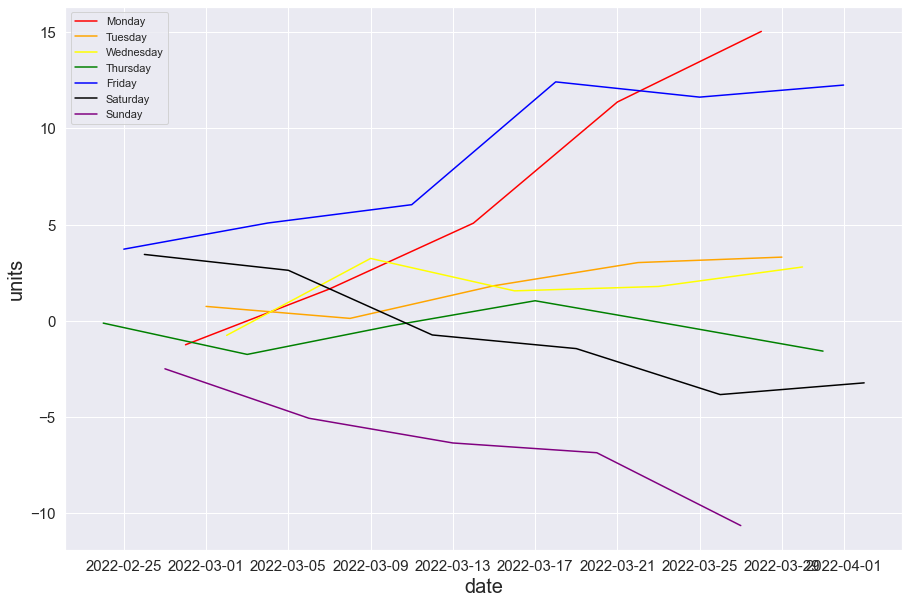

In [6]:
# seaborn formatting
sns.set(rc={"figure.figsize":(15, 10)})
sns.set_palette('bright', 8)
plt.xlabel('date', fontsize=20)
plt.ylabel('units', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'black', 'purple']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for day, color in zip(days, colors):
    dow_df = df.groupby(['date', 'dow_name']).aggregate('sum').reset_index()
    dow_df = dow_df[dow_df['dow_name'] == day]
    dow_df['profit'] = dow_df['random_forest_profit'].cumsum()
    
    sns.lineplot(data=dow_df, x='date', y='profit', color=color, label=day)


dow_df = df.groupby(['dow_name']).aggregate('sum').reset_index().sort_values(['random_forest_profit'], ascending=False)
dow_df[['dow_name', 'random_forest_profit']]

### Profit Analysis

,model,record,accuracy,profit
4,random_forest,159 - 110,59,17.95
1,decision_tree,151 - 118,56,2.67
5,avg,149 - 120,55,-2.46
2,gradient_boosted,145 - 124,54,-10.81
3,neural_network,140 - 129,52,-16.57
0,linear,141 - 128,52,-17.92


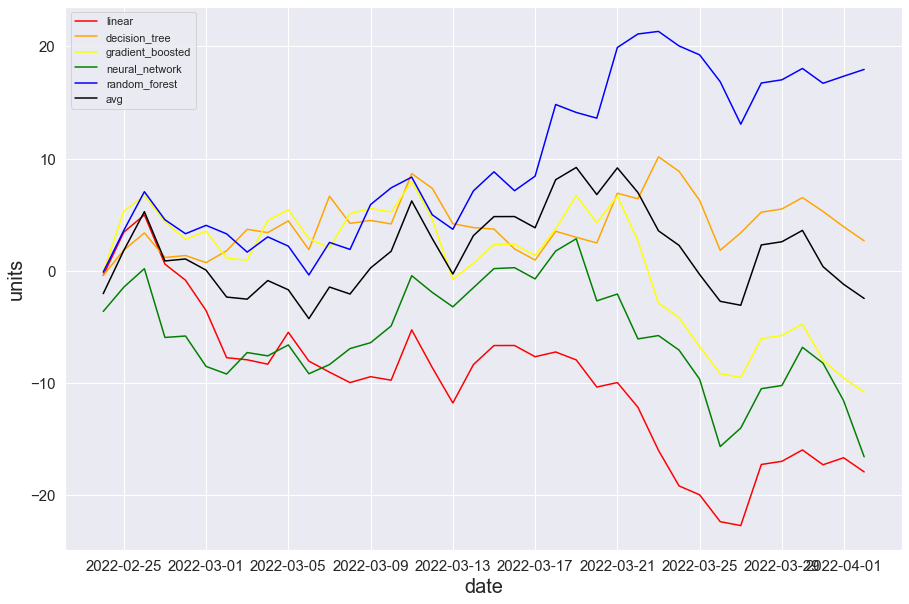

In [7]:
# seaborn formatting
sns.set(rc={"figure.figsize":(15, 10)})
plt.xlabel('date', fontsize=20)
plt.ylabel('units', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Totals
totals = {'model': [], 'record': [], 'accuracy': [], 'profit': []}


colors = ['red', 'orange', 'yellow', 'green', 'blue', 'black']
for model, col in zip(models, colors):
    # Line graph
    sns.lineplot(data=df.groupby(['date']).sum(), x='date', y=df.groupby(['date']).sum()[f'{model}_profit'].cumsum(), color=col, label=model)
    
    # Totals
    profit = df[model + '_profit'].sum()
    correct = df[df[model + '_hit'] == True][model + '_hit'].count()
    wrong = df[df[model + '_hit'] == False][model + '_hit'].count()
    
    totals['model'].append(model)
    totals['record'].append(f'{correct} - {wrong}')
    totals['accuracy'].append(round((correct / (correct + wrong)) * 100))
    totals['profit'].append(round(profit, 2))
    

totals = pd.DataFrame(totals).sort_values(['profit', 'accuracy'], ascending=False)
totals

# Algorithmic

###  Profit Analysis

In [8]:
algo_df = pd.read_csv('backend/predictions/3p_predictions_algo.csv').drop(['Unnamed: 0'], axis=1)

# Convert date to datetime
algo_df['date'] = pd.to_datetime(algo_df['date'])

# Sort by date
algo_df = algo_df.sort_values(['date'], ascending=True)

# Merge dataframes
algo_df = pd.merge(algo_df, totals_df, left_on=['date', 'visitor', 'home'], right_on=['date', 'visitor', 'home'], how='left')
algo_df = algo_df.drop_duplicates(['date', 'visitor', 'home']).dropna(axis=0)

# Hit or bust
algo_df['hit'] = (((algo_df['3p'] > algo_df['line']) & (algo_df['prediction'] > algo_df['line'])) |
                    ((algo_df['3p'] < algo_df['line']) & (algo_df['prediction'] < algo_df['line'])))

# Potential payout
algo_df['potential_profit'] = np.where(algo_df['3p'] > algo_df['line'], algo_df['over'], algo_df['under'])
algo_df['potential_profit'] = np.where(algo_df['potential_profit'] > 0, algo_df['potential_profit'] / 100, -100 / algo_df['potential_profit'])
algo_df['profit'] = np.where(algo_df['hit'], algo_df['potential_profit'], -1)
algo_df['accumulative_profit'] = algo_df['profit'].cumsum()

### Profit over Time

,model,record,accuracy,profit
0,algorithmic,83 - 71,54,-5.65


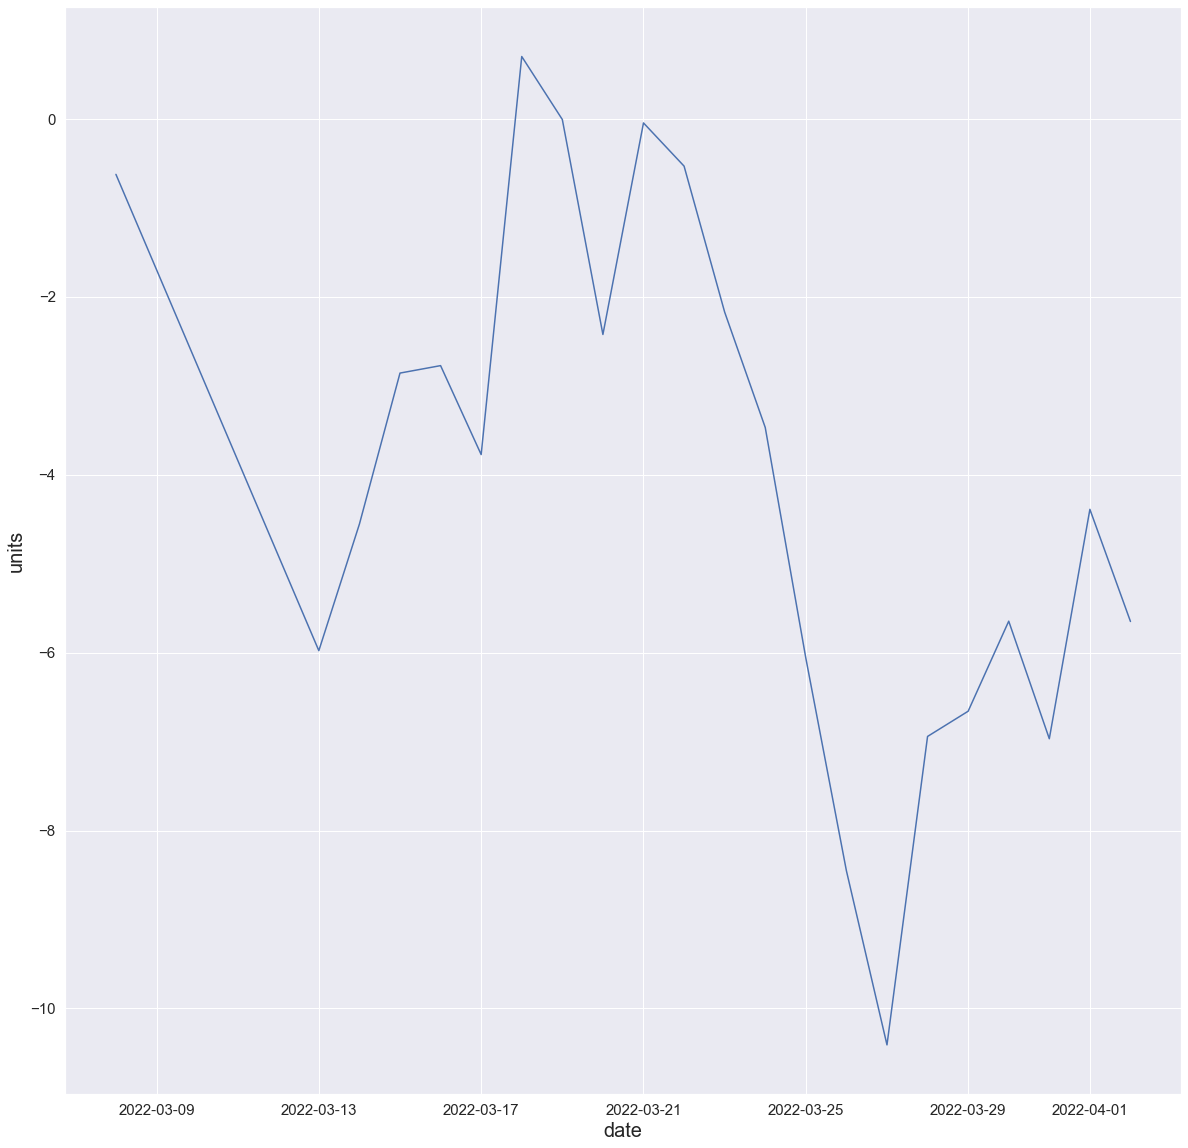

In [9]:
# seaborn formatting
sns.set(rc={"figure.figsize":(20, 20)})
plt.xlabel('date', fontsize=20)
plt.ylabel('units', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

sns.lineplot(data=algo_df.groupby(['date']).sum(), x='date', y=algo_df.groupby(['date']).sum()['profit'].cumsum())

# Total
totals = {'model': ['algorithmic'], 'record': [], 'accuracy': [], 'profit': []}

profit = algo_df['profit'].sum()
correct = algo_df[algo_df['hit'] == True]['hit'].count()
wrong = algo_df[algo_df['hit'] == False]['hit'].count()

totals['record'].append(f'{correct} - {wrong}')
totals['accuracy'].append(round((correct / (correct + wrong)) * 100))
totals['profit'].append(round(profit, 2))

totals = pd.DataFrame(totals).sort_values(['profit', 'accuracy'], ascending=False)
totals

## Make picks

In [10]:
models = ['linear', 'decision_tree', 'gradient_boosted', 'neural_network', 'random_forest', 'avg']
today_df['profit'] = 0
today_df['accuracy'] = 0
today_df['count'] = 0
for model in models:
    # Differential profit and accuarcy
    temp = df.groupby([model + '_diff'])[[model + '_hit', model + '_profit']].aggregate(['sum', 'count'])
    temp['accuracy'] = round(temp[(model + '_hit', 'sum')] / temp[(model + '_hit', 'count')] * 100)
    temp['profit'] = round(temp[(model + '_profit', 'sum')], 2)
    temp['count'] = temp[(model + '_hit', 'count')]
    temp = temp.reset_index()
    temp.columns = [col[0] for col in temp.columns]
    temp = temp[[model + '_diff', 'accuracy', 'profit', 'count']]

    # Compute difference between line and prediction
    today_df[model + '_diff'] = myround(today_df[model] - today_df['line'])
    
    # Merge differential's profit and accuracy
    today_df = pd.merge(today_df, temp, left_on = [model + '_diff'], right_on=[model + '_diff'], how='left', suffixes=('', '_' + model))

In [11]:
models = ['linear', 'decision_tree', 'gradient_boosted', 'neural_network', 'random_forest', 'avg']

# Expected profit
for model in models:
    today_df[model + '_expected_profit'] = today_df['profit_' + model] * today_df['accuracy_' + model]

# Find model with max expected profit
models = ['linear', 'decision_tree', 'gradient_boosted', 'neural_network', 'random_forest', 'avg']
models = [model + '_expected_profit' for model in models]

today_df = today_df.fillna(0)

today_df['total_expected_profit'] = \
            today_df['linear_expected_profit'] + today_df['decision_tree_expected_profit'] + \
            today_df['gradient_boosted_expected_profit'] + today_df['neural_network_expected_profit'] + \
            today_df['random_forest_expected_profit'] + today_df['avg_expected_profit']

today_df['max_expected_profit'] = today_df[models].idxmax(axis=1)
today_df['max_expected_profit'] = today_df['max_expected_profit'].apply(lambda x: '_'.join(x.split('_')[:-2]))

# Predictions for models that result in max expected profit
predictions = []
for index, row in today_df.iterrows():
    model = row['max_expected_profit']
    predictions.append(row[model])

today_df['prediction'] = predictions
today_df['over_under'] = np.where(today_df['prediction'] > today_df['line'], 'o', 'u')

In [12]:
models = ['linear', 'decision_tree', 'gradient_boosted', 'neural_network', 'random_forest', 'avg']
expected_profits = [model + '_expected_profit' for model in models]

for model in models:
    today_df[model] = np.where(today_df[model] > today_df['line'], 'o', 'u')

cols = ['date', 'visitor', 'home', 'line'] + ['total_expected_profit', 'max_expected_profit'] + models + expected_profits
today_df[cols].sort_values(['total_expected_profit'], ascending=False)

,date,visitor,home,line,total_expected_profit,max_expected_profit,linear,decision_tree,gradient_boosted,neural_network,random_forest,avg,linear_expected_profit,decision_tree_expected_profit,gradient_boosted_expected_profit,neural_network_expected_profit,random_forest_expected_profit,avg_expected_profit
2,2022-04-03,Golden State Warriors,Sacramento Kings,26.5,1824.71,random_forest,u,u,o,o,u,u,-59.92,4.40,296.77,251.14,929.94,402.38
0,2022-04-03,Dallas Mavericks,Milwaukee Bucks,26.5,1134.32,random_forest,u,o,o,o,u,o,-491.47,188.49,296.77,145.14,929.94,65.45
7,2022-04-03,Washington Wizards,Boston Celtics,24.5,841.08,random_forest,u,o,o,o,o,o,-491.47,188.49,296.77,251.14,530.70,65.45
6,2022-04-03,Portland Trail Blazers,San Antonio Spurs,24.5,831.93,random_forest,o,o,o,o,u,o,-421.12,188.49,296.77,-230.00,929.94,67.85
1,2022-04-03,Denver Nuggets,Los Angeles Lakers,24.5,791.69,random_forest,u,o,o,o,o,o,-491.47,245.10,296.77,145.14,530.70,65.45
3,2022-04-03,Miami Heat,Toronto Raptors,24.5,362.34,random_forest,u,o,o,o,o,o,-491.47,188.49,296.77,-230.00,530.70,67.85
4,2022-04-03,Minnesota Timberwolves,Houston Rockets,27.5,33.91,gradient_boosted,o,o,o,o,u,o,-421.12,245.10,296.77,145.14,-297.43,65.45
5,2022-04-03,New Orleans Pelicans,Los Angeles Clippers,24.5,-978.69,gradient_boosted,u,u,u,u,u,u,-59.92,-260.00,-13.57,-217.77,-297.43,-130.00


In [13]:
today_df[['date', 'visitor', 'home', 'random_forest', 'line', 'over', 'under']].tail(today_df.shape[0])

,date,visitor,home,random_forest,line,over,under
0,2022-04-03,Dallas Mavericks,Milwaukee Bucks,u,26.5,-130.0,-110.0
1,2022-04-03,Denver Nuggets,Los Angeles Lakers,o,24.5,-125.0,-115.0
2,2022-04-03,Golden State Warriors,Sacramento Kings,u,26.5,105.0,-145.0
3,2022-04-03,Miami Heat,Toronto Raptors,o,24.5,-140.0,105.0
4,2022-04-03,Minnesota Timberwolves,Houston Rockets,u,27.5,-135.0,100.0
5,2022-04-03,New Orleans Pelicans,Los Angeles Clippers,u,24.5,120.0,-165.0
6,2022-04-03,Portland Trail Blazers,San Antonio Spurs,u,24.5,-105.0,-130.0
7,2022-04-03,Washington Wizards,Boston Celtics,o,24.5,100.0,-140.0


In [14]:
today_df = today_df[['date', 'visitor', 'home', 'over_under', 'prediction', 'line', 'over', 'under']]
algo_predictions = pd.read_csv('backend/predictions/3p_predictions_algo.csv').drop(['Unnamed: 0'], axis=1)
algo_predictions = algo_predictions.append(today_df, ignore_index=True)
algo_predictions['date'] = pd.to_datetime(algo_predictions['date'])
algo_predictions = algo_predictions.drop_duplicates(['date', 'home', 'visitor'])
algo_predictions.to_csv('backend/predictions/3p_predictions_algo.csv')